In [1]:
import pandas as pd
import numpy as np
from collections import Counter

from sklearn.decomposition import PCA
from sklearn.decomposition import TruncatedSVD


from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier

import matplotlib.pyplot as plt
import koreanize_matplotlib
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import silhouette_score

import pickle

import warnings
warnings.filterwarnings('ignore')

In [2]:
df = pd.read_csv('df2.csv')

In [3]:
df

,고객ID,최초거래년월,최종거래년월,거래활동기간,거래 연속성 비율,거래 밀도 지수,비활성화 기간 비율,총 거래 공백 개월수,월평균 거래금액,월평균 거래건수,최다가맹점업종명,업종다양성지수,신규유입고객,최다가맹점_광역시도,거래지역다양성지수,총거래금액,총거래건수,승인건수점수,승인금액점수,승인점수
0,2002967708,202312,202312,1,100.00,5.00,0.00,0,210000.00,5.00,대형할인점,2,1,경상북도,2,210000,5.0,1,1,2
1,2004066711,202312,202312,1,100.00,2.50,0.00,0,40000.00,2.50,대형할인점,1,1,경기도,1,40000,2.5,1,1,2
2,2004166649,202312,202312,1,100.00,15.00,0.00,0,220000.00,15.00,기타잡화,6,1,경상북도,3,220000,15.0,1,1,2
3,2004326617,202312,202312,1,100.00,2.50,0.00,0,10000.00,2.50,편 의 점,1,1,경기도,1,10000,2.5,1,1,2
4,2004432929,202312,202312,1,100.00,5.00,0.00,0,460000.00,5.00,대형할인점,2,1,경기도,2,460000,5.0,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915212,9999918728,202105,202310,30,43.33,4.23,0.57,17,443076.92,4.23,대형할인점,6,1,대구광역시,1,5760000,55.0,1,1,2
915213,9999933174,202109,202212,16,43.75,9.29,0.56,9,611428.57,9.29,약 국,14,1,경기도,4,4280000,65.0,2,1,3
915214,9999972286,202101,202101,1,100.00,2.50,0.00,0,10000.00,2.50,편 의 점,1,0,대구광역시,1,10000,2.5,1,1,2
915215,9999981183,202101,202211,23,100.00,21.20,0.00,0,371304.35,21.20,일반한식,31,0,경상북도,6,8540000,487.5,3,1,4


# 주거래 부거래

In [4]:
main = pd.read_csv('주거래.csv')
surb = pd.read_csv('부거래.csv')

In [5]:
main['고객상태'] = '1'

In [6]:
surb['고객상태'] = '-1'

In [7]:
main = main[['고객ID','고객상태']]

In [8]:
surb = surb[['고객ID','고객상태']]

In [9]:
df = df.merge(main[['고객ID', '고객상태']], on='고객ID', how='left')  # 주거래 기준으로 병합

In [10]:
df = df.merge(surb[['고객ID', '고객상태']], on='고객ID', how='left', suffixes=('_주거래', '_부거래'))

In [11]:
df['고객상태'] = df['고객상태_주거래'].combine_first(df['고객상태_부거래'])

In [12]:
df['고객상태'] = df['고객상태'].fillna(0)

In [13]:
df['고객상태'].unique()

array([0, '1', '-1'], dtype=object)

In [14]:
df = df.drop(columns=['고객상태_주거래', '고객상태_부거래'])

In [15]:
df

,고객ID,최초거래년월,최종거래년월,거래활동기간,거래 연속성 비율,거래 밀도 지수,비활성화 기간 비율,총 거래 공백 개월수,월평균 거래금액,월평균 거래건수,...,업종다양성지수,신규유입고객,최다가맹점_광역시도,거래지역다양성지수,총거래금액,총거래건수,승인건수점수,승인금액점수,승인점수,고객상태
0,2002967708,202312,202312,1,100.00,5.00,0.00,0,210000.00,5.00,...,2,1,경상북도,2,210000,5.0,1,1,2,0
1,2004066711,202312,202312,1,100.00,2.50,0.00,0,40000.00,2.50,...,1,1,경기도,1,40000,2.5,1,1,2,0
2,2004166649,202312,202312,1,100.00,15.00,0.00,0,220000.00,15.00,...,6,1,경상북도,3,220000,15.0,1,1,2,0
3,2004326617,202312,202312,1,100.00,2.50,0.00,0,10000.00,2.50,...,1,1,경기도,1,10000,2.5,1,1,2,0
4,2004432929,202312,202312,1,100.00,5.00,0.00,0,460000.00,5.00,...,2,1,경기도,2,460000,5.0,1,1,2,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
915212,9999918728,202105,202310,30,43.33,4.23,0.57,17,443076.92,4.23,...,6,1,대구광역시,1,5760000,55.0,1,1,2,0
915213,9999933174,202109,202212,16,43.75,9.29,0.56,9,611428.57,9.29,...,14,1,경기도,4,4280000,65.0,2,1,3,0
915214,9999972286,202101,202101,1,100.00,2.50,0.00,0,10000.00,2.50,...,1,0,대구광역시,1,10000,2.5,1,1,2,0
915215,9999981183,202101,202211,23,100.00,21.20,0.00,0,371304.35,21.20,...,31,0,경상북도,6,8540000,487.5,3,1,4,0


# 출장유무

In [16]:
data = pd.read_csv('카드고객데이터.csv')

In [17]:
problem_businesses = [
    "CATV홈쇼핑", "PG상품권", "비씨카드 정산용(할인)", "비씨카드 정산용가맹점", "생명보험",
    "이동통신요금", "인터넷P/G", "일반보험(판매)", "전기차충전소", "전자상거래상품권", 
    "호텔", "통신서비스/소득공제대상", "통신판매업1"
]

data['최다가맹점_광역시도'] = np.where(
    data['최다가맹점업종명'].isin(problem_businesses),
    data['자택_시도'],
    data['최다가맹점_광역시도'])

In [18]:
data = data[['고객ID','최다가맹점_광역시도','자택_시도','자택_시군구']]

# 잠깐 정리!!

In [19]:
df = df.merge(data, on =['고객ID','최다가맹점_광역시도'], how = 'inner')

In [20]:
df['최다가맹점_광역시도'].unique()

array(['경상북도', '경기도', '대구광역시', '경상남도', '대전광역시', '서울특별시', '부산광역시', '인천광역시',
       '전라남도', '강원특별자치도', '제주특별자치도', '충청남도', '전북특별자치도', '충청북도', '광주광역시',
       '울산광역시', '세종특별자치시'], dtype=object)

In [21]:
df['자택_시도'].unique()

array(['대구광역시', '인천광역시', '경상북도', '경기도', '서울특별시', '경상남도', '대전광역시', '부산광역시',
       '울산광역시', '전라남도', '강원특별자치도', '제주특별자치도', '충청남도', '전북특별자치도', '충청북도',
       '광주광역시', '세종특별자치시'], dtype=object)

In [22]:
df['출장여부'] = df['최다가맹점_광역시도'].eq(df['자택_시도']).astype(int)

In [23]:
df.drop(['최다가맹점_광역시도', '자택_시도', '자택_시군구'], axis=1, inplace=True)

# 전처리

## 오브젝트

In [24]:
category_mapping = {
 '주유소': [
        'SK주유소', 'GS주유소', '쌍용S-OIL', '현대정유(오일뱅크)', 'E1가스충전소', '쌍용S-OIL가스충전소',
        'GS가스충전소', '전기차충전소', '현대정유가스충전소', '유류판매', '윤활유전문판매','SK가스충전소','LPG취급점'
    ],
    '의류판매': ['정장', '스포츠의류', '아동의류', '맞춤복점', '단체복', '내의판매','기타의류'],
    '도서/서적': ['일반서적', '전문서적', '기타서적문구'],
    '교육': [
        '보습학원', '예·체능계학원', '외국어학원', '독서실', '학원', '기타 교육기관',
        '초중고교육기관', '학습지교육', '기능학원', '유아원'
    ],
    '여행/숙박': [
        '특급호텔', '콘도', '1급 호텔', '2급 호텔', '기타숙박업', '관광여행'
    ],
    '대중교통': ['택시', '철도', '고속버스', '여객선'],
    '스포츠/레저': [
        '기타레져업소', '스포츠·레져용품', '스크린골프', '헬스클럽', '골프연습장', '볼 링 장',
        '종합레져타운', '레져업소', '당구장', '수 영 장', '골프경기장', '골프용품 전문점'
    ],
    '보험': ['생명보험', '손해보험', '기타보험'],
    '뷰티/헤어/잡화': [
        '미용원', '피부미용실', '이용원', '화장품', '미용재료', '신 발', '기타잡화',
        '안경', '액세서리', '가 방', '귀금속', '시 계'
    ],
    '홈데코/가전': [
        '조명기구', '일반가구', '주방용구', '주방용식기', '인테리어전문', '기타가구', '카페트,커튼,천막,지물', '침구·수예점', '가전제품', '안마/스포츠마사지', '냉열기기'
    ],
    '문구/사무': [
        '완구점', '문구용품', '사무서비스', '기타 사무용품', '사무·통신기기수리', '사무용 OA기기'
    ],
    '자동차/공구': [
        '자동차정비', '기계공구', '주차장', '가정용품수리', '자동차부품', '자동차시트·타이어',
        '세차장', '이륜차판매', '가타자동차서비스', '기타수리서비스', '보일러·펌프·샷시', '렌터카', '카인테리어'
    ],
    '건축/자재/농업': [
        '옷감·직물', '건축용 요업제품', '페인트', '기타전기제품', '목재·석재·철물',
        '기타건축자재', '비료,사료,종자', '기타농업관련', '농기계'
    ],
    '문화/여가/반려': [
        '문화취미기타', '화방·표구점', '영화관', '사우나', '화원', '티켓', '수족관',
        '민예·공예품', '동물병원', '애완동물'
    ],
    '술/유흥': ['주점', '노 래 방', '유흥주점', '단란주점', '칵테일바', '주류판매점'],
    '통신': [
        '이동통신요금', '통신판매업1', '일반(통신판매)', '통신서비스/소득공제비대상', '통신기기'
    ],
    '컴퓨터': ['소프트웨어', '컴퓨터'],
    '생활': [
        '편 의 점', '슈퍼마켓', '정수기', '세탁소', '농협하나로클럽', '농,축협직영매장', '대형할인점',
        '구내매점(국가기관등)', '기념품점', '조세서비스', '공공요금대행서비스/소득공제비대상',
        '공공요금대행서비스/소득공제대상', '자사카드발행백화점'
    ],
    '의료/건강': [
        '약 국', '의 원', '종합병원', '병 원(응급실운영)', '치과의원', '한 의 원',
        '치과병원', '의료용품', '한약방', '한방병원', '건강진단', '기타의료기관 및 기타의료기기'
    ],
    '식료품': [
        '농·축·수산품', '기타음료식품', '기타건강식품', '인삼제품', '홍삼제품',
        '농축수산가공품', '스넥', '제과점', '미곡상', '정육점'
    ],
    '기타': ['기타1', '기타4', '화물운송','DP&E'],
    '온라인쇼핑': [
        '인터넷P/G', '인터넷Mall','인터넷종합Mall', 'CATV홈쇼핑'
    ],
    '상품권':['PG상품권', '전자상거래상품권',
        '상품권전문판매', '상 품 권'
],
    '음식점': ['일반한식', '서양음식', '중국식', '일식·회집', '갈비전문점','한정식'],
    '기타 서비스업': [
        '기타 전문점', '연 쇄 점', '위탁급식업', '업종미등록', '기타유통업', '출판 및 인쇄물',
        '가례서비스업', '보관및 창고업', '혼례서비스업', '부동산중개·임대','종합용역', '기타용역서비스', '기타대인서비스'
    ],
    '비영리' : ['비영리/비대상','비영리/대상'],
    '비씨카드 정산': ['비씨카드 정산용가맹점','비씨카드 정산용(할인)']

}

In [25]:
df['업종_그룹'] = df['최다가맹점업종명'].map(
    lambda x: next((key for key, values in category_mapping.items() if x in values), '기타')
)
df.drop('최다가맹점업종명', axis=1, inplace=True)

print(df['업종_그룹'].value_counts())

업종_그룹
음식점         292980
생활          247108
온라인쇼핑        96388
기타 서비스업      47661
의료/건강        39238
식료품          24018
주유소          16357
보험           14276
대중교통         10444
교육            8504
스포츠/레저        8209
통신            6076
뷰티/헤어/잡화      4479
기타            4121
문화/여가/반려      2138
자동차/공구        1887
의류판매          1747
상품권           1717
문구/사무         1544
홈데코/가전        1394
비영리           1302
도서/서적          795
술/유흥           766
여행/숙박          637
건축/자재/농업       513
컴퓨터            123
비씨카드 정산         18
Name: count, dtype: int64


In [26]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 834440 entries, 0 to 834439
Data columns (total 21 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   고객ID         834440 non-null  int64  
 1   최초거래년월       834440 non-null  int64  
 2   최종거래년월       834440 non-null  int64  
 3   거래활동기간       834440 non-null  int64  
 4   거래 연속성 비율    834440 non-null  float64
 5   거래 밀도 지수     834440 non-null  float64
 6   비활성화 기간 비율   834440 non-null  float64
 7   총 거래 공백 개월수  834440 non-null  int64  
 8   월평균 거래금액     834440 non-null  float64
 9   월평균 거래건수     834440 non-null  float64
 10  업종다양성지수      834440 non-null  int64  
 11  신규유입고객       834440 non-null  int64  
 12  거래지역다양성지수    834440 non-null  int64  
 13  총거래금액        834440 non-null  int64  
 14  총거래건수        834440 non-null  float64
 15  승인건수점수       834440 non-null  int64  
 16  승인금액점수       834440 non-null  int64  
 17  승인점수         834440 non-null  int64  
 18  고객상태         834440 non-

In [27]:
df.to_csv('cluster_data.csv', index=False, encoding='utf-8-sig', float_format='%.2f')

# 문자형

In [28]:
label_encoder = LabelEncoder()
df['고객상태_encoded'] = label_encoder.fit_transform(df['고객상태'].astype(str))

scaler = StandardScaler()
df['고객상태_scaled'] = scaler.fit_transform(df[['고객상태_encoded']])

print("고객상태 스케일링 완료")

고객상태 스케일링 완료


## 수치형

In [29]:
quantitative_features = ['거래활동기간', '거래 연속성 비율', '총거래건수', '총거래금액', '월평균 거래건수']
qualitative_features = ['거래지역다양성지수', '업종다양성지수', '출장여부', '고객상태']
all_features = quantitative_features + qualitative_features

scaler = MinMaxScaler()
df_scaled = df.copy() 
df_scaled[all_features] = scaler.fit_transform(df_scaled[all_features])

weights = {
    '거래활동기간': 1.5,
    '거래 연속성 비율': 1.5,
    '총거래건수': 2.0,
    '총거래금액': 1.0,
    '월평균 거래건수': 2.0,
    '거래지역다양성지수': 1.0,
    '업종다양성지수': 1.2, 
    '출장여부' : 1.2,
    '고객상태': 1.3 
}

for feature, weight in weights.items():
    df_scaled[feature] *= weight

# 주성분수

In [30]:
quantitative_features = ['거래활동기간', '거래 연속성 비율', '총거래건수', '총거래금액', '월평균 거래건수']

pca = PCA(n_components=2)
quantitative_pca = pca.fit_transform(df_scaled[quantitative_features])

df_scaled['양적_PCA_1'] = quantitative_pca[:, 0]
df_scaled['양적_PCA_2'] = quantitative_pca[:, 1]

print("양적 로열티 PCA 설명 분산 비율:", pca.explained_variance_ratio_)

양적 로열티 PCA 설명 분산 비율: [0.62610266 0.3551775 ]


In [31]:
qualitative_features = ['거래지역다양성지수', '업종다양성지수', '출장여부', '고객상태']

pca = PCA(n_components=2)
qualitative_pca = pca.fit_transform(df_scaled[qualitative_features])

df_scaled['질적_PCA_1'] = qualitative_pca[:, 0]
df_scaled['질적_PCA_2'] = qualitative_pca[:, 1]

print("질적 로열티 PCA 설명 분산 비율:", pca.explained_variance_ratio_)

질적 로열티 PCA 설명 분산 비율: [0.57269756 0.33709012]


# 군집수

## 엘보우 그래프

### 양적

In [32]:
wcss = []
for i in range(1, 11): 
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(df_scaled[quantitative_features])
    wcss.append(kmeans.inertia_)

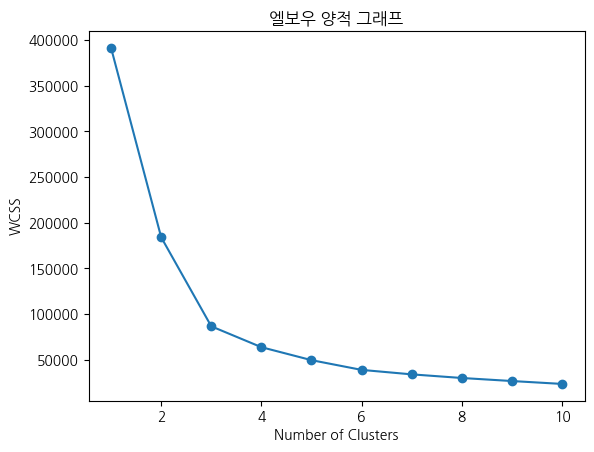

In [33]:
plt.plot(range(1, 11), wcss, marker='o')
plt.title('엘보우 양적 그래프')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

### 질적

In [34]:
wcss_qual = []
for i in range(1, 11):
    kmeans_qual = KMeans(n_clusters=i, random_state=42)
    kmeans_qual.fit(df_scaled[qualitative_features])
    wcss_qual.append(kmeans_qual.inertia_)

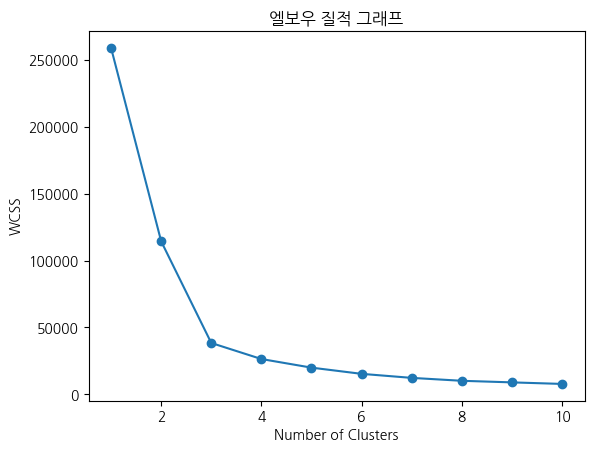

In [35]:
plt.plot(range(1, 11), wcss_qual, marker='o')
plt.title('엘보우 질적 그래프')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

## DBI

In [36]:
for n_clusters in range(2, 11): 
    kmeans_quant = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans_quant.fit_predict(df_scaled[quantitative_features])
    dbi_score = davies_bouldin_score(df_scaled[quantitative_features], cluster_labels)
    print(f"양적 로열티 군집 수: {n_clusters}, Davies-Bouldin Index: {dbi_score}")

양적 로열티 군집 수: 2, Davies-Bouldin Index: 0.8046712482424662
양적 로열티 군집 수: 3, Davies-Bouldin Index: 0.6412415454755566
양적 로열티 군집 수: 4, Davies-Bouldin Index: 0.7427528230575524
양적 로열티 군집 수: 5, Davies-Bouldin Index: 0.7046600654082632
양적 로열티 군집 수: 6, Davies-Bouldin Index: 0.7021634569434846
양적 로열티 군집 수: 7, Davies-Bouldin Index: 0.750661192453765
양적 로열티 군집 수: 8, Davies-Bouldin Index: 0.7898885662922783
양적 로열티 군집 수: 9, Davies-Bouldin Index: 0.8155533558516315
양적 로열티 군집 수: 10, Davies-Bouldin Index: 0.8167767341470376


In [37]:
for n_clusters in range(2, 11):  
    kmeans_qual = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans_qual.fit_predict(df_scaled[qualitative_features])
    dbi_score = davies_bouldin_score(df_scaled[qualitative_features], cluster_labels)
    print(f"질적 로열티 군집 수: {n_clusters}, Davies-Bouldin Index: {dbi_score}")

질적 로열티 군집 수: 2, Davies-Bouldin Index: 0.4762002356378273
질적 로열티 군집 수: 3, Davies-Bouldin Index: 0.4209794257242037
질적 로열티 군집 수: 4, Davies-Bouldin Index: 0.5396055653221475
질적 로열티 군집 수: 5, Davies-Bouldin Index: 0.5503238994221438
질적 로열티 군집 수: 6, Davies-Bouldin Index: 0.6467977411257335
질적 로열티 군집 수: 7, Davies-Bouldin Index: 0.6812608869751325
질적 로열티 군집 수: 8, Davies-Bouldin Index: 0.7028365071997623
질적 로열티 군집 수: 9, Davies-Bouldin Index: 0.7417154055581475
질적 로열티 군집 수: 10, Davies-Bouldin Index: 0.7730842656993093


# 클러스터링

In [38]:
kmeans_quant = KMeans(n_clusters=3, random_state=42)
df_scaled['양적로열티_클러스터'] = kmeans_quant.fit_predict(df_scaled[['양적_PCA_1', '양적_PCA_2']])


kmeans_qual = KMeans(n_clusters=3, random_state=42)
df_scaled['질적로열티_클러스터'] = kmeans_qual.fit_predict(df_scaled[['질적_PCA_1', '질적_PCA_2']])

In [39]:
combined_features = ['양적_PCA_1', '양적_PCA_2', '질적_PCA_1', '질적_PCA_2']
pca = PCA(n_components=2)
combined_pca = pca.fit_transform(df_scaled[combined_features])

df_scaled['혼합_PCA_1'] = combined_pca[:, 0]
df_scaled['혼합_PCA_2'] = combined_pca[:, 1]

# 클러스터링 믹스

In [40]:
df_scaled['최종_세그먼트'] = (
    df_scaled['양적로열티_클러스터'].astype(str) + '-' +
    df_scaled['질적로열티_클러스터'].astype(str)
)

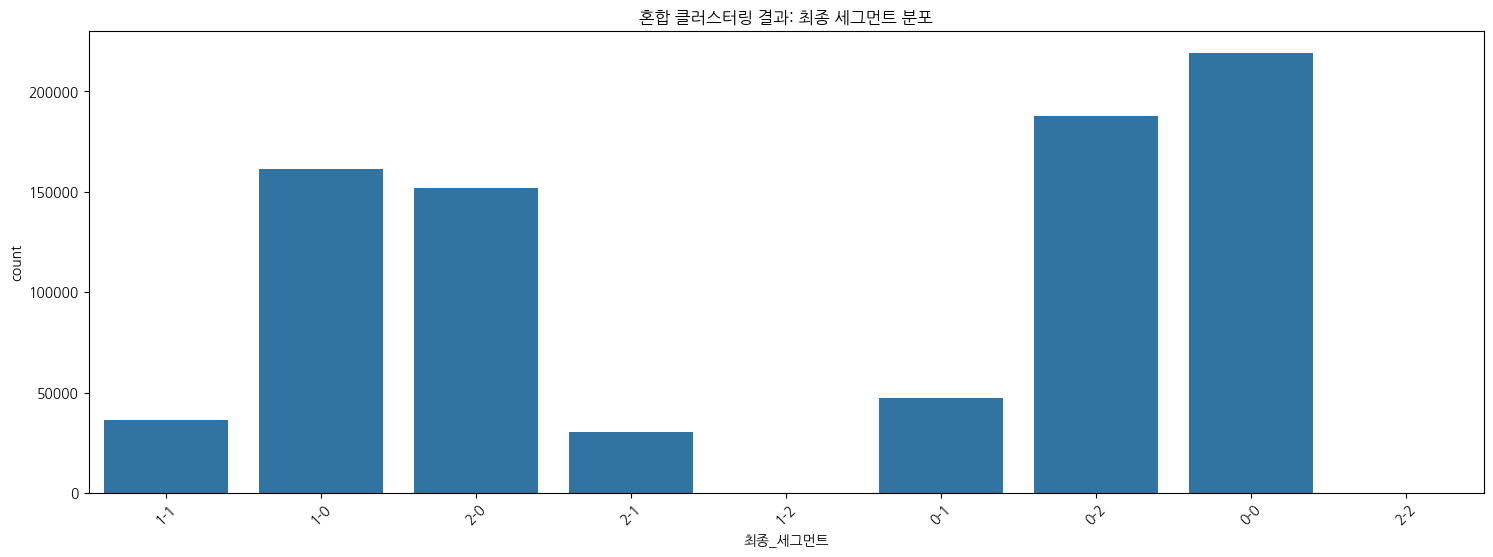

In [41]:
plt.figure(figsize=(18, 6))
sns.countplot(x='최종_세그먼트', data=df_scaled)
plt.title("혼합 클러스터링 결과: 최종 세그먼트 분포")
plt.xticks(rotation=45)
plt.show()

**평가**

In [42]:
cluster_sizes = df_scaled['최종_세그먼트'].value_counts()
print(cluster_sizes)

최종_세그먼트
0-0    219006
0-2    187663
1-0    161143
2-0    152120
0-1     47483
1-1     36243
2-1     30547
1-2       184
2-2        51
Name: count, dtype: int64


In [43]:
sample_data = df_scaled[['혼합_PCA_1', '혼합_PCA_2']].sample(n=10000, random_state=42)
sample_labels = df_scaled['최종_세그먼트'].sample(n=10000, random_state=42)

silhouette_avg = silhouette_score(sample_data, sample_labels)
print(f"샘플링된 데이터의 Silhouette Score: {silhouette_avg}")

샘플링된 데이터의 Silhouette Score: 0.3145876072579697


# 개같이 수정

In [44]:
combined_features = ['양적_PCA_1', '양적_PCA_2', '질적_PCA_1', '질적_PCA_2']

for n_clusters in range(7, 32):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = kmeans.fit_predict(df_scaled[combined_features])
    dbi = davies_bouldin_score(df_scaled[combined_features], cluster_labels)
    print(f"혼합 데이터 군집 수: {n_clusters}, Davies-Bouldin Index: {dbi}")

혼합 데이터 군집 수: 7, Davies-Bouldin Index: 0.7666742778575975
혼합 데이터 군집 수: 8, Davies-Bouldin Index: 0.729517595247575
혼합 데이터 군집 수: 9, Davies-Bouldin Index: 0.7051216069384648
혼합 데이터 군집 수: 10, Davies-Bouldin Index: 0.7172088830306953
혼합 데이터 군집 수: 11, Davies-Bouldin Index: 0.6893221942105788
혼합 데이터 군집 수: 12, Davies-Bouldin Index: 0.7041120535877825
혼합 데이터 군집 수: 13, Davies-Bouldin Index: 0.7287596435628763
혼합 데이터 군집 수: 14, Davies-Bouldin Index: 0.7576724266905186
혼합 데이터 군집 수: 15, Davies-Bouldin Index: 0.7131168804230885
혼합 데이터 군집 수: 16, Davies-Bouldin Index: 0.7169034220370436
혼합 데이터 군집 수: 17, Davies-Bouldin Index: 0.7452925752179717
혼합 데이터 군집 수: 18, Davies-Bouldin Index: 0.7597332031009733
혼합 데이터 군집 수: 19, Davies-Bouldin Index: 0.772179241379532
혼합 데이터 군집 수: 20, Davies-Bouldin Index: 0.7754550774276616
혼합 데이터 군집 수: 21, Davies-Bouldin Index: 0.7977236069748022
혼합 데이터 군집 수: 22, Davies-Bouldin Index: 0.8128396098374762
혼합 데이터 군집 수: 23, Davies-Bouldin Index: 0.8234512164080465
혼합 데이터 군집 수: 24, Da

In [ ]:
optimal_clusters = 11
kmeans_combined = KMeans(n_clusters=optimal_clusters, random_state=42)
df_scaled['혼합_클러스터'] = kmeans_combined.fit_predict(df_scaled[combined_features])

In [46]:
def calculate_silhouette_score(df_scaled, pca_columns, segment_column, sample_size=10000):
    """
    샘플링을 사용하여 Silhouette Score를 계산합니다.
    
    Args:
        df_scaled (DataFrame): 클러스터링 결과가 포함된 데이터프레임
        pca_columns (list): PCA 컬럼 이름 리스트
        segment_column (str): 클러스터링 결과 컬럼 이름
        sample_size (int): 샘플링 크기 (기본값: 10000)
    
    Returns:
        float: 샘플링된 데이터의 Silhouette Score
    """
    sample_data = df_scaled[pca_columns].sample(n=min(sample_size, len(df_scaled)), random_state=42)
    sample_labels = df_scaled.loc[sample_data.index, segment_column]

    silhouette_avg = silhouette_score(sample_data, sample_labels)
    return silhouette_avg

silhouette_avg = calculate_silhouette_score(
    df_scaled,
    pca_columns=['혼합_PCA_1', '혼합_PCA_2'],
    segment_column='혼합_클러스터',
    sample_size=5000 
)

print(f"샘플링된 데이터의 Silhouette Score: {silhouette_avg}")

샘플링된 데이터의 Silhouette Score: 0.3688904288913854


# 정해진대로하면 고개이 너무 분류가 안된다. 어떻게 사람을 11개로 분류 하다못해 MBTI도 16개인데 그런이유로 30개로 나눈 후 적당히 합쳐서 할 예정 - 논문참고

In [47]:
optimal_clusters = 30
kmeans_combined = KMeans(n_clusters=optimal_clusters, random_state=42)
df_scaled['혼합_클러스터'] = kmeans_combined.fit_predict(df_scaled[combined_features])

In [48]:
df_scaled.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 834440 entries, 0 to 834439
Data columns (total 33 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   고객ID          834440 non-null  int64  
 1   최초거래년월        834440 non-null  int64  
 2   최종거래년월        834440 non-null  int64  
 3   거래활동기간        834440 non-null  float64
 4   거래 연속성 비율     834440 non-null  float64
 5   거래 밀도 지수      834440 non-null  float64
 6   비활성화 기간 비율    834440 non-null  float64
 7   총 거래 공백 개월수   834440 non-null  int64  
 8   월평균 거래금액      834440 non-null  float64
 9   월평균 거래건수      834440 non-null  float64
 10  업종다양성지수       834440 non-null  float64
 11  신규유입고객        834440 non-null  int64  
 12  거래지역다양성지수     834440 non-null  float64
 13  총거래금액         834440 non-null  float64
 14  총거래건수         834440 non-null  float64
 15  승인건수점수        834440 non-null  int64  
 16  승인금액점수        834440 non-null  int64  
 17  승인점수          834440 non-null  int64  
 18  고객상태

In [49]:
top10_industries = (
    df_scaled.groupby('혼합_클러스터')['업종_그룹']
    .value_counts()
    .groupby(level=0)
    .head(10)  
    .reset_index(name='count') 
)

top10_industries_aggregated = (
    top10_industries.groupby('혼합_클러스터')['업종_그룹']
    .apply(lambda x: x.tolist())  
    .reset_index(name='상위_10_업종')  
)

df_scaled = df_scaled.merge(top10_industries_aggregated, on='혼합_클러스터', how='left')

df_scaled.head()

,고객ID,최초거래년월,최종거래년월,거래활동기간,거래 연속성 비율,거래 밀도 지수,비활성화 기간 비율,총 거래 공백 개월수,월평균 거래금액,월평균 거래건수,...,양적_PCA_2,질적_PCA_1,질적_PCA_2,양적로열티_클러스터,질적로열티_클러스터,혼합_PCA_1,혼합_PCA_2,최종_세그먼트,혼합_클러스터,상위_10_업종
0,2002967708,202312,202312,0.0,1.5,5.0,0.0,0,210000.0,0.007359,...,-0.405012,1.075006,0.058126,1,1,1.164707,-0.289922,1-1,16,"[음식점, 생활, 기타 서비스업, 온라인쇼핑, 식료품, 보험, 대중교통, 의료/건강..."
1,2004066711,202312,202312,0.0,1.5,2.5,0.0,0,40000.0,0.000000,...,-0.404559,1.085341,0.027075,1,1,1.179159,-0.281366,1-1,16,"[음식점, 생활, 기타 서비스업, 온라인쇼핑, 식료품, 보험, 대중교통, 의료/건강..."
2,2004166649,202312,202312,0.0,1.5,15.0,0.0,0,220000.0,0.036794,...,-0.406824,-0.078228,-0.277510,1,0,0.922395,-0.668714,1-0,9,"[생활, 음식점, 식료품, 의료/건강, 보험, 주유소, 온라인쇼핑, 스포츠/레저, ..."
3,2004326617,202312,202312,0.0,1.5,2.5,0.0,0,10000.0,0.000000,...,-0.404558,-0.052718,-0.351427,1,0,0.957991,-0.647267,1-0,9,"[생활, 음식점, 식료품, 의료/건강, 보험, 주유소, 온라인쇼핑, 스포츠/레저, ..."
4,2004432929,202312,202312,0.0,1.5,5.0,0.0,0,460000.0,0.007359,...,-0.405013,-0.063054,-0.320376,1,0,0.943538,-0.655824,1-0,9,"[생활, 음식점, 식료품, 의료/건강, 보험, 주유소, 온라인쇼핑, 스포츠/레저, ..."


In [50]:
import numpy as np
from sklearn.metrics import jaccard_score
from itertools import combinations

def weighted_jaccard(list1, list2, max_weight=1.0):
    weights1 = np.linspace(max_weight, 0, len(list1), endpoint=False)
    weights2 = np.linspace(max_weight, 0, len(list2), endpoint=False)
    
    set1 = set(list1)
    set2 = set(list2)
    
    intersection = set1 & set2
    union = set1 | set2
    
    weight_sum = sum([weights1[list1.index(item)] if item in list1 else 0 for item in intersection]) + \
                 sum([weights2[list2.index(item)] if item in list2 else 0 for item in intersection])
    union_sum = sum(weights1) + sum(weights2) - weight_sum
    
    return weight_sum / union_sum if union_sum > 0 else 0

def merge_clusters(df, target_clusters=20, max_weight=1.0):
    clusters = df['혼합_클러스터'].unique().tolist()
    cluster_representations = {c: df[df['혼합_클러스터'] == c]['상위_10_업종'].iloc[0] for c in clusters}
    
    while len(clusters) > target_clusters:
        max_similarity = -1
        merge_pair = None

        for cluster1, cluster2 in combinations(clusters, 2):
            similarity = weighted_jaccard(
                cluster_representations[cluster1],
                cluster_representations[cluster2],
                max_weight=max_weight
            )
            if similarity > max_similarity:
                max_similarity = similarity
                merge_pair = (cluster1, cluster2)
        
        if merge_pair:
            c1, c2 = merge_pair
            new_cluster = f"{c1}_{c2}"  
            
            merged_representation = list(set(cluster_representations[c1] + cluster_representations[c2]))
            merged_representation.sort(key=lambda x: (
                -max(
                    cluster_representations[c1].index(x) if x in cluster_representations[c1] else float('inf'),
                    cluster_representations[c2].index(x) if x in cluster_representations[c2] else float('inf')
                )
            ))
            
            cluster_representations[new_cluster] = merged_representation
            clusters.remove(c1)
            clusters.remove(c2)
            clusters.append(new_cluster)
            df.loc[df['혼합_클러스터'].isin([c1, c2]), '혼합_클러스터'] = new_cluster

    return df

df_scaled = merge_clusters(df_scaled, target_clusters=20, max_weight=1.0)

In [51]:
num_clusters = df_scaled['혼합_클러스터'].nunique()
print(f"최종 클러스터 개수: {num_clusters}")

최종 클러스터 개수: 20


In [52]:
cluster_distribution = df_scaled['혼합_클러스터'].value_counts()
print(cluster_distribution)

혼합_클러스터
19_24_7_13_0    148595
3               102642
20               74693
12               72040
9                69184
28               43145
17_1             42617
15_5             37479
26_22            34297
16_4             32385
14               31149
18_8             26410
11               25932
2_25             24329
23               21242
29               15366
10               10539
27                8801
6                 7825
21                5770
Name: count, dtype: int64


In [62]:
import pandas as pd

pd.set_option('display.max_colwidth', None) 

representative_industries = (
    df_scaled.groupby('혼합_클러스터')['상위_10_업종']
    .first()
)

representative_industries

혼합_클러스터
0         [음식점, 생활, 온라인쇼핑, 의료/건강, 교육, 식료품, 기타 서비스업, 주유소, 대중교통, 스포츠/레저]
1             [음식점, 생활, 온라인쇼핑, 의료/건강, 식료품, 대중교통, 보험, 주유소, 통신, 기타 서비스업]
2                [음식점, 온라인쇼핑, 생활, 의료/건강, 식료품, 주유소, 스포츠/레저, 통신, 보험, 기타]
3               [생활, 음식점, 온라인쇼핑, 기타 서비스업, 의료/건강, 주유소, 교육, 보험, 통신, 식료품]
4        [생활, 음식점, 식료품, 의료/건강, 보험, 주유소, 온라인쇼핑, 스포츠/레저, 뷰티/헤어/잡화, 대중교통]
5             [음식점, 생활, 온라인쇼핑, 기타 서비스업, 의료/건강, 주유소, 통신, 식료품, 보험, 대중교통]
6         [음식점, 생활, 온라인쇼핑, 의료/건강, 식료품, 기타 서비스업, 주유소, 대중교통, 스포츠/레저, 교육]
7         [음식점, 생활, 온라인쇼핑, 의료/건강, 식료품, 기타 서비스업, 주유소, 대중교통, 스포츠/레저, 교육]
8         [음식점, 생활, 온라인쇼핑, 의료/건강, 식료품, 기타 서비스업, 주유소, 대중교통, 스포츠/레저, 교육]
9         [음식점, 생활, 기타 서비스업, 온라인쇼핑, 식료품, 보험, 대중교통, 의료/건강, 주유소, 스포츠/레저]
10        [생활, 음식점, 온라인쇼핑, 의료/건강, 기타 서비스업, 식료품, 주유소, 대중교통, 교육, 스포츠/레저]
11        [음식점, 생활, 기타 서비스업, 온라인쇼핑, 식료품, 의료/건강, 대중교통, 주유소, 스포츠/레저, 보험]
12            [기타 서비스업, 음식점, 생활, 보험, 온라인쇼핑, 의료/건강, 주유소, 대중교통, 비영리, 교육]
13            [음식점, 생활, 보험, 의료/건강, 온라인쇼핑, 대중교통, 주유소, 식료품, 기타 서비스업, 기타

In [54]:
def calculate_silhouette_score_after_merge(df_scaled, pca_columns, segment_column, sample_size=10000):
    """
    자카드 유사도로 병합한 결과를 기반으로 Silhouette Score를 계산합니다.
    
    Args:
        df_scaled (DataFrame): 클러스터링 결과가 포함된 데이터프레임 (병합 후)
        pca_columns (list): PCA 컬럼 이름 리스트
        segment_column (str): 병합된 클러스터 결과 컬럼 이름
        sample_size (int): 샘플링 크기 (기본값: 10000)
    
    Returns:
        float: 샘플링된 데이터의 Silhouette Score
    """
    df_scaled[segment_column] = df_scaled[segment_column].astype(str)

    sample_data = df_scaled[pca_columns].sample(n=min(sample_size, len(df_scaled)), random_state=42)
    sample_labels = df_scaled.loc[sample_data.index, segment_column]

    silhouette_avg = silhouette_score(sample_data, sample_labels)
    return silhouette_avg

silhouette_avg_after_merge = calculate_silhouette_score_after_merge(
    df_scaled,
    pca_columns=['혼합_PCA_1', '혼합_PCA_2'],  
    segment_column='혼합_클러스터',  
    sample_size=5000 
)

print(f"자카드 유사도 기반으로 병합 후 Silhouette Score: {silhouette_avg_after_merge}")

자카드 유사도 기반으로 병합 후 Silhouette Score: 0.1396921014228422


In [55]:
def redefine_clusters(df, cluster_column):
    """
    클러스터 이름을 0부터 N까지, 클러스터 크기 순으로 재정의합니다.
    
    Args:
        df (DataFrame): 클러스터링 결과가 포함된 데이터프레임
        cluster_column (str): 클러스터 컬럼 이름
        
    Returns:
        DataFrame: 클러스터 이름이 재정의된 데이터프레임
    """
    cluster_sizes = df[cluster_column].value_counts().sort_values(ascending=False)
    
    cluster_mapping = {old_cluster: new_cluster for new_cluster, old_cluster in enumerate(cluster_sizes.index)}
    
    df[cluster_column] = df[cluster_column].map(cluster_mapping)
    
    return df

df_scaled = redefine_clusters(df_scaled, '혼합_클러스터')

print(df_scaled['혼합_클러스터'].value_counts())

혼합_클러스터
0     148595
1     102642
2      74693
3      72040
4      69184
5      43145
6      42617
7      37479
8      34297
9      32385
10     31149
11     26410
12     25932
13     24329
14     21242
15     15366
16     10539
17      8801
18      7825
19      5770
Name: count, dtype: int64


# 추천시스템

In [58]:
features = ['거래활동기간', '월평균 거래건수', '총거래금액', '월평균 거래금액', '고객상태']
X = df_scaled[features] 
y = df_scaled['혼합_클러스터'] 

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

knn = KNeighborsClassifier(n_neighbors=5)
knn.fit(X_scaled, y)

def get_top_merchants(cluster_data):
    """
    클러스터 내 최다 빈도 상위 10개 업종 반환
    """
    return ', '.join(
        cluster_data['상위_10_업종'] 
        .explode() 
        .value_counts() 
        .index[:10] 
    )

cluster_top_merchants = (
    df_scaled.groupby('혼합_클러스터')  
    .apply(get_top_merchants)  
    .reset_index(name='Top_10_Merchants')  
)

def recommend_for_new_customer(new_customer_data):
    """
    새로운 고객 데이터를 받아 군집을 예측하고 해당 군집의 상위 10개 업종 추천
    """
    scaled_new_data = scaler.transform([new_customer_data]) 
    predicted_cluster = knn.predict(scaled_new_data)[0]  
    return cluster_top_merchants.loc[
        cluster_top_merchants['혼합_클러스터'] == predicted_cluster,  
        'Top_10_Merchants'
    ].values[0]

# 추천시스템 저장

In [59]:
import pickle

with open('recommendation_system.pkl', 'wb') as f:
    pickle.dump({'knn': knn, 'scaler': scaler, 'cluster_top_merchants': cluster_top_merchants}, f)

print("추천 시스템 데이터와 모델 저장 완료!")

추천 시스템 데이터와 모델 저장 완료!
